In [30]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
import string
import matplotlib.pyplot as plt

In [3]:
from sklearn import neighbors

In [4]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [5]:
con=sqlite3.connect('final_data.sqlite')

In [6]:
## We had cleansed and saved the final data for TSNE assignment. We use the same for this assignment.

review_data=pd.read_sql_query("""Select * from  Reviews""",con)

In [7]:
review_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit ca...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak books watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read aloud- nice rhythm well ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl p...


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sn

## Data Sampling, Time Based Splitting

In [9]:
## To avoid Out of Memory error, let's sample some rows and try on the sample data
sampled_data=review_data[['Time','Score','CleanedText']].sample(100000)

In [10]:
# Sort the data based on time for time based splitting.
sampled_data_sort=sampled_data.sort_values('Time')

In [11]:
# Check the data again
print(sampled_data_sort.head())
sampled_data_sort['Score'].value_counts()

          Time     Score                                        CleanedText
424  944092800  Positive  beetlejuic well written movi       everyth exc...
261  951523200  Positive  happen say name three time michael keaten star...
325  959990400  Positive  im get crazy im look beatlejuic french version...
242  962236800  Positive  receiv shipment could hard wait tri product  l...
837  965779200  Positive  much easier use wilson past colors  color vibr...


Positive    84414
Negative    15586
Name: Score, dtype: int64

In [12]:
#Create Train/Test Split of data (based on time, as we have sorted data already)

Train_data=sampled_data_sort.iloc[0:70000]
print("Train data dim :",Train_data.shape)

Test_data=sampled_data_sort.iloc[70000:]
print("Test data dim :",Test_data.shape)

Train data dim : (70000, 3)
Test data dim : (30000, 3)


## KNN With BOW

In [13]:
# Create BOW with Train data
count_vect=CountVectorizer()
vocab=count_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
Train_counts=count_vect.transform(Train_data['CleanedText'].values)
Train_counts.get_shape()

(70000, 55393)

In [14]:
type(Train_counts)

scipy.sparse.csr.csr_matrix

In [33]:
Y_train_Polarity=Train_data['Score'].values

In [31]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

##### Find optimal K Value using 10 fold CV

In [19]:
# KNN on Train data 
## Find best value of K using 10 fold CV
k_list=list(range(0,50))
K_odd=[k for k in k_list if k%2 !=0]
cv_scores=[]
for k in K_odd:
    BOW_KNN=neighbors.KNeighborsClassifier(k)
    scores = cross_val_score(BOW_KNN, Train_counts, Y_train_Polarity, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

misclassification_rate=[1-r for r in cv_scores]
# determining best k
optimal_k = K_odd[misclassification_rate.index(min(misclassification_rate))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 13.


In [30]:
print(cv_scores)

[0.8096421540585862, 0.8461283240256507, 0.8540142731314866, 0.8552428200895037, 0.8557714139725945, 0.8556571323387752, 0.8557714323413995, 0.8553856915201162, 0.8554428404999996, 0.8551571139653055, 0.8551427955962086, 0.8548856649787162, 0.8548142568154512, 0.8547428119169087, 0.8544284955871705, 0.8543570690539344, 0.8543713506871706, 0.8541999527259467, 0.8540714037431482, 0.8539142527186583, 0.8536285649591836, 0.8534571363860056, 0.8534000037314871, 0.8532571486274053, 0.853228558830612]


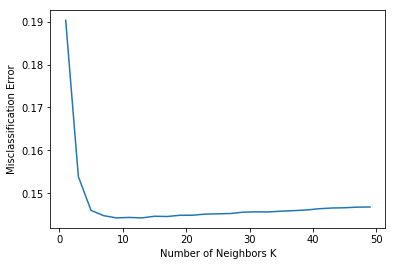

the misclassification error for each k value is :  [0.19036 0.15387 0.14599 0.14476 0.14423 0.14434 0.14423 0.14461 0.14456
 0.14484 0.14486 0.14511 0.14519 0.14526 0.14557 0.14564 0.14563 0.1458
 0.14593 0.14609 0.14637 0.14654 0.1466  0.14674 0.14677]


In [22]:
plt.plot(K_odd, misclassification_rate)

#for xy in zip(K_odd, np.round(misclassification_rate,3)):
#    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(misclassification_rate,5))

###### Check Test Accuracy

In [23]:
BOW_KNN=neighbors.KNeighborsClassifier(n_neighbors=13)
BOW_KNN.fit(Train_counts,Y_train_Polarity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')

In [24]:
Test_counts=count_vect.transform(Test_data['CleanedText'].values)
Test_counts.get_shape()

(30000, 55393)

In [27]:
Test_Predict=BOW_KNN.predict(Test_counts)

In [28]:
Test_acc = accuracy_score(Test_data['Score'].values, Test_Predict) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, Test_acc))


The accuracy of the knn classifier for k = 13 is 83.336667%


* Thus, our Test Accuracy using BOW KNN is around 83 %, which is close to our CV accuracy of around 85%
* We can say that our BOW KNN is not overfitting
* Other things which we could try are :scale the data, use a specific KNN algo such as KD Tree, try bi-grams instead of unigrams etc.

## KNN with TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
## Create a tf-idf vectorizer-unigram

## For Train data

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
tf_idf_vocab=tf_idf_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
tf_idf_train_counts=tf_idf_vect.transform(Train_data['CleanedText'].values)
tf_idf_train_counts.get_shape()

(70000, 54964)

In [15]:
## For Test Data
tf_idf_test_counts=tf_idf_vect.transform(Test_data['CleanedText'].values)
tf_idf_test_counts.get_shape()

(30000, 54964)

#### Find Optimal K value for TF-IDF

In [23]:
# KNN on Train data 
## Find best value of K using 10 fold CV
tf_idf_k_list=list(range(0,50))
tf_idf_K_odd=[k for k in tf_idf_k_list if k%2 !=0]
tf_idf_cv_scores=[]
for k in tf_idf_K_odd:
    tf_idf_KNN=neighbors.KNeighborsClassifier(k)
    tf_idf_scores = cross_val_score(tf_idf_KNN, tf_idf_train_counts, Y_train_Polarity, cv=10, scoring='accuracy')
    tf_idf_cv_scores.append(tf_idf_scores.mean())

tf_idf_misclassification_rate=[1-r for r in tf_idf_cv_scores]
# determining best k
tf_idf_optimal_k = tf_idf_K_odd[tf_idf_misclassification_rate.index(min(tf_idf_misclassification_rate))]
print('\nThe optimal number of neighbors is %d.' % tf_idf_optimal_k)


The optimal number of neighbors is 9.


In [24]:
print(tf_idf_cv_scores)

[0.8439571252787168, 0.8546286171816335, 0.8607000376451902, 0.8623713805139932, 0.8630714233702623, 0.8629714743892137, 0.8628571764311961, 0.8625571968370274, 0.862214335609622, 0.8620000927492729, 0.8619857927530628, 0.8619572090790101, 0.8617286254067066, 0.8611429070335287, 0.8611714662142866, 0.8608571886615171, 0.8609572131513132, 0.860742939682509, 0.8608000743763864, 0.8608286396822173, 0.8606429253959199, 0.8605143478422754, 0.8601286233498552, 0.8601000396769687, 0.8599714988603514]


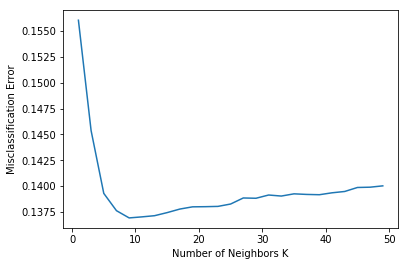

the misclassification error for each k value is :  [0.15604 0.14537 0.1393  0.13763 0.13693 0.13703 0.13714 0.13744 0.13779
 0.138   0.13801 0.13804 0.13827 0.13886 0.13883 0.13914 0.13904 0.13926
 0.1392  0.13917 0.13936 0.13949 0.13987 0.1399  0.14003]


In [25]:
plt.plot(tf_idf_K_odd, tf_idf_misclassification_rate)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(tf_idf_misclassification_rate,5))

#### Check Test Accuracy

In [26]:
tf_idf_KNN=neighbors.KNeighborsClassifier(n_neighbors=tf_idf_optimal_k)
tf_idf_KNN.fit(tf_idf_train_counts,Y_train_Polarity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [27]:
Test_Predict_tf_idf=tf_idf_KNN.predict(tf_idf_test_counts)

In [28]:
Test_acc_tf_idf = accuracy_score(Test_data['Score'].values, Test_Predict_tf_idf) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tf_idf_optimal_k, Test_acc_tf_idf))


The accuracy of the knn classifier for k = 9 is 83.960000%


* We see that Test Accuracy with TF-IDF is almost equal to Test Accuracy with BOW

## KNN with Avg Word2Vec

In [16]:
from gensim.models import Word2Vec
from gensim.models import keyedvectors

#### Preprocessing text and creating avg word vectors for train and test data

In [17]:
## Split each text row into words for train data
sent_split_train=[sent.split() for sent in Train_data['CleanedText'].values]
print(sent_split_train[0])

['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'movie']


In [18]:
## Train Word2Vec Model.Consider words with min frequency 3.

w2vModel=Word2Vec(sent_split_train,min_count=3,size=50,workers=2)

In [19]:
## W2V Train Vocab
w2v_words_train = list(w2vModel.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  22349
sample words  ['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'movie', 'happen', 'say', 'name', 'three', 'time', 'michael', 'star', 'comedi', 'two', 'coupl', 'live', 'old', 'stori', 'house', 'come', 'back', 'suppli', 'store', 'sudden', 'get', 'caught', 'insid', 'bridg', 'start', 'tumbl', 'lake', 'board', 'catch', 'them', 'theyv', 'got', 'hope', 'up', 'small', 'dog', 'step', 'car']


In [36]:
print(w2vModel.wv.most_similar('show'))

[('shown', 0.8134374618530273), ('letter', 0.7582100629806519), ('imag', 0.7494668960571289), ('print', 0.7385543584823608), ('video', 0.724541962146759), ('text', 0.7226758003234863), ('page', 0.7109229564666748), ('receipt', 0.7064568400382996), ('inspect', 0.6982311606407166), ('confirm', 0.6928055286407471)]


In [17]:
## Find Avg Word Vectors for each sentence. Use for both Train and Test Data

def AvgWord2Vec(sent_split):
    '''
    This function takes the sentences from the text and computes avg word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text
    output:
    avg_sent_vectors: List of avg word vectors of dimension 50
    '''
    avg_sent_vectors=[]
    for sent in sent_split:
        sent_vect=np.zeros(50)
        cnt_word=0
        for word in sent:
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                cnt_word+=1
                sent_vect+=word_vec
        if cnt_word != 0:
            sent_vect/=cnt_word
        avg_sent_vectors.append(sent_vect)
    return(avg_sent_vectors)
            

In [40]:
avg_vectors_train=AvgWord2Vec(sent_split_train)
print(avg_vectors_train[0])

[-6.97999308e-04  5.28442559e-02  3.45157362e-01  1.01740464e-01
 -6.86518845e-02  3.60810341e-01 -4.30521374e-01 -1.33634473e-02
  2.68657674e-01  1.72403344e-01 -1.24174105e-01 -2.95325268e-01
  3.97508746e-01 -6.03620206e-02  2.38875882e-02 -4.11606689e-01
 -4.42514302e-01  4.90166120e-01  1.35990607e-01  1.54694055e-01
 -4.17662551e-01  2.10643278e-01 -6.56334138e-03  2.55758159e-01
 -1.82628400e-01  6.88633112e-01 -1.09119027e-01 -4.94516636e-01
 -2.02103362e-01  5.44719720e-02  2.59796872e-01 -5.67040167e-02
 -6.43684995e-02  2.85885778e-01  2.76091228e-01  5.75670877e-01
 -5.12987186e-01  3.19221892e-01  7.45358316e-01  3.46882556e-01
 -2.96533585e-03 -7.64579436e-02  3.29741597e-01  3.77642468e-01
  6.67268357e-02  6.35999202e-01  9.04566461e-01  3.14475198e-01
  9.12057447e-02 -2.54162572e-01]


In [20]:
## Split each text row into words for test data
sent_split_test=[sent.split() for sent in Test_data['CleanedText'].values]
print(sent_split_test[0])

['ingredi', 'get', 'harder', 'harder', 'find', 'expensive', 'th', 'last', 'bottl', 'found', '1', '10', 'size', '1', '2', 'price', 'thank', 'you']


In [42]:
avg_vectors_test=AvgWord2Vec(sent_split_test)
print(avg_vectors_test[0])

[-0.21278598 -0.04094665 -0.05528239 -0.11327226 -0.70508126 -0.09158412
  0.19070062 -0.01884494 -0.13528853  0.73725942  0.48150643 -0.50242352
  0.71782864 -0.65615754 -0.54473841 -0.58591975 -0.51819316 -0.17975949
  0.16770733  0.20157985 -0.39195612 -0.6232702   0.2944977  -0.24431774
  0.16763766 -0.04704335 -0.21272596  0.62193771  0.15621722 -0.0375582
  0.40095529  0.25448149  0.52664429  0.39802628  0.20205752  0.81332998
  0.87904     0.05811206  0.35853625  0.10330404 -0.63893384  0.19123873
  0.0478396  -0.37278706 -0.305197    0.56215076  0.73727349  0.06203579
  0.33860495 -0.00320454]


#### Finding Optimal value of K

In [43]:
# KNN on Train data 
## Find best value of K using 10 fold CV
w2v_k_list=list(range(0,50))
w2v_K_odd=[k for k in w2v_k_list if k%2 !=0]
w2v_cv_scores=[]
for k in w2v_K_odd:
    w2v_KNN=neighbors.KNeighborsClassifier(k)
    w2v_scores = cross_val_score(w2v_KNN, avg_vectors_train, Y_train_Polarity, cv=10, scoring='accuracy')
    w2v_cv_scores.append(w2v_scores.mean())

w2v_misclassification_rate=[1-r for r in w2v_cv_scores]
# determining best k
w2v_optimal_k = w2v_K_odd[w2v_misclassification_rate.index(min(w2v_misclassification_rate))]
print('\nThe optimal number of neighbors is %d.' % w2v_optimal_k)


The optimal number of neighbors is 21.


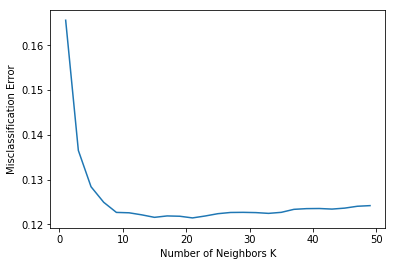

the misclassification error for each k value is :  [0.16557 0.13651 0.12841 0.12494 0.12269 0.1226  0.12214 0.12159 0.1219
 0.12183 0.12146 0.12189 0.1224  0.12267 0.1227  0.12264 0.12247 0.1227
 0.12337 0.12353 0.12356 0.12343 0.12364 0.12406 0.1242 ]


In [44]:
plt.plot(w2v_K_odd, w2v_misclassification_rate)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(w2v_misclassification_rate,5))

#### Check Test Accuracy

In [45]:
w2v_KNN=neighbors.KNeighborsClassifier(n_neighbors=w2v_optimal_k)
w2v_KNN.fit(avg_vectors_train,Y_train_Polarity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')

In [46]:
Test_Predict_w2v=w2v_KNN.predict(avg_vectors_test)

In [47]:
Test_acc_w2v = accuracy_score(Test_data['Score'].values, Test_Predict_w2v) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (w2v_optimal_k, Test_acc_w2v))


The accuracy of the knn classifier for k = 21 is 85.866667%


* Accuracy of avg Word2Vec model is better than BOW and TF-IDF model.

## KNN With TF-IDF Weighted Word2Vec

#### Creating tf-idf weighted word vectors

In [21]:
## Generate TF-IDF features using the TF Vectorizer that we used in KNN TF-IDF

features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[0:100])

some sample features(unique words in the corpus) ['00', '000', '0000', '00001', '000013', '0001', '000111052bulk', '0001bottl', '0002251337', '000dave', '000iuvit', '000kwh', '000mg', '000su', '001', '00100', '005', '0069615', '00703', '00704', '0099', '00dollar', '00for', '00gr', '00i', '00that', '00z', '01', '0100', '013', '01317', '01318', '017', '02', '022', '025', '025913', '026220', '028', '02th', '03', '0300', '031', '032', '03510', '035273', '037', '038', '039', '03jan12', '04', '040', '042', '044000025298', '04472700', '045', '0472066978', '0475', '048', '04830', '04oz', '05', '050', '050oz', '051', '05140', '052', '055', '05manganese2mgchromium5mcgpotassium11mgcholin', '06', '0610', '0625', '0631', '0688', '06oz', '07', '07003and', '07003fyi', '0738551856', '08', '080', '0810', '085', '089', '08m07c0', '09', '090', '0947', '095', '097', '09follow', '0carb', '0check', '0cholesterol', '0clock', '0g', '0g12', '0g5', '0gcholest', '0gcholesterol']


In [22]:
## Clean '-' from sentences
import re
def clean_wrd(wrd):
    cleanhash=re.compile('-')
    cleanwrd=re.sub(cleanhash,'',wrd)
    return cleanwrd

In [23]:
def AvgWord2Vectfidf(sent_split,tf_idf_counts):
    '''
    This function takes the sentences from the text and tf idf counts and computes tf idf weighted word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text and tf idf counts
    output:
    tf_idf_sent_vectors: List of tf idf weighted word vectors of dimension 50
    '''
    tf_idf_sent_vectors=[]
    for sent in sent_split:
        sent_vect=np.zeros(50)
        weight_sum=0
        for word in sent:
            word=clean_wrd(word)
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                try:
                    tf_idf = tf_idf_counts[row, features.index(word)]
                    sent_vec += (word_vec * tf_idf)
                    weight_sum += tf_idf
                except:
                    continue
        if weight_sum != 0:
            sent_vect/=weight_sum
        tf_idf_sent_vectors.append(sent_vect)
    return(tf_idf_sent_vectors)
            

In [24]:
tf_idf_vectors_train=AvgWord2Vectfidf(sent_split_train,tf_idf_train_counts)

In [25]:
print(len(tf_idf_vectors_train))

70000


In [26]:
tf_idf_vectors_test=AvgWord2Vectfidf(sent_split_test,tf_idf_test_counts)
print(len(tf_idf_vectors_test))

30000


#### Finding Optimal K value

In [34]:
# KNN on Train data 
## Find best value of K using 10 fold CV
w2v1_k_list=list(range(0,50))
w2v1_K_odd=[k for k in w2v1_k_list if k%2 !=0]
w2v1_cv_scores=[]
for k in w2v1_K_odd:
    w2v1_KNN=neighbors.KNeighborsClassifier(k)
    w2v1_scores = cross_val_score(w2v1_KNN, tf_idf_vectors_train, Y_train_Polarity, cv=10, scoring='accuracy')
    w2v1_cv_scores.append(w2v1_scores.mean())

w2v1_misclassification_rate=[1-r for r in w2v1_cv_scores]
# determining best k
tf_idf_w2v_optimal_k = w2v1_K_odd[w2v1_misclassification_rate.index(min(w2v1_misclassification_rate))]
print('\nThe optimal number of neighbors is %d.' % tf_idf_w2v_optimal_k)


The optimal number of neighbors is 1.


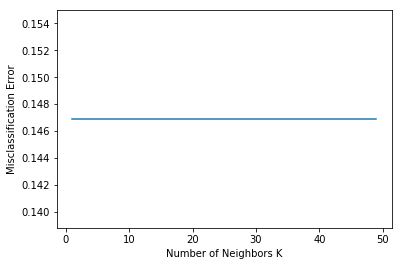

the misclassification error for each k value is :  [0.14689 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689
 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689
 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689 0.14689]


In [35]:
plt.plot(w2v1_K_odd, w2v1_misclassification_rate)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(w2v1_misclassification_rate,5))

* Strangely the error rate for all K is same

#### Check Test Accuracy

In [36]:
w2v_tfidf_KNN=neighbors.KNeighborsClassifier(n_neighbors=tf_idf_w2v_optimal_k)
w2v_tfidf_KNN.fit(tf_idf_vectors_train,Y_train_Polarity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [37]:
Test_Predict_w2v_tf_idf=w2v_tfidf_KNN.predict(tf_idf_vectors_test)

In [38]:
Test_acc_w2v_tf_idf = accuracy_score(Test_data['Score'].values, Test_Predict_w2v_tf_idf) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (tf_idf_w2v_optimal_k, Test_acc_w2v_tf_idf))


The accuracy of the knn classifier for k = 1 is 82.320000%


* The accuracy with tf-idf weighted KNN with K=1 is less than that of BOW,tf-idf and w2v